In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.mnist.load_data()
xtrain, xtest = (x[:,:,:,np.newaxis]/255 for x in (xtrain, xtest))

In [3]:
X = X_input = keras.layers.Input((28,28,1))
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(10, activation='softmax')(X)
M = keras.Model(X_input, X)
M.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
M_frezze = keras.Model(X_input, X)
M_frezze.trainable = False
M_frezze.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [4]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=64, epochs=5, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 44us/step - loss: 0.5639 - acc: 0.8562 - val_loss: 0.3360 - val_acc: 0.9097
Epoch 2/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.3266 - acc: 0.9101 - val_loss: 0.2967 - val_acc: 0.9174
Epoch 3/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.2966 - acc: 0.9178 - val_loss: 0.2810 - val_acc: 0.9210
Epoch 4/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.2831 - acc: 0.9214 - val_loss: 0.2752 - val_acc: 0.9229
Epoch 5/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.2744 - acc: 0.9230 - val_loss: 0.2757 - val_acc: 0.9214


In [9]:
class BestInput(keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(BestInput, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.best_input = self.add_weight(
            shape=input_shape[1:],
            initializer='glorot_uniform', name='best_input',
            #regularizer=keras.regularizers.l2(),
            constraint=keras.constraints.non_neg())
        super(BestInput, self).build(input_shape)
    
    def call(self, inputs):
        x = inputs
        return x*self.best_input + (1-x)*K.stop_gradient(self.best_input)
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [10]:
X = X_input = keras.layers.Input((28,28,1))
X_BestInput = BestInput()
X = X_BestInput(X)
X = M_frezze(X)
BI = keras.Model(X_input, X)
BI.compile('nadam', 'mse')

In [14]:
def optimize_best_input(target, start_with_random_array=False):
    if start_with_random_array:
        BI.set_weights([np.random.random((28,28,1))])
    else:
        BI.set_weights([xtest[np.random.randint(0, len(xtest))]])
    BI.fit(np.ones((1,28,28,1)), keras.utils.to_categorical([target], 10), epochs=5000, verbose=0)
    best_input = X_BestInput.get_weights()[0]
    best_input_pred = M.predict(best_input[np.newaxis,:,:,:])[0]
    plt.title(f'predicted as {np.argmax(best_input_pred)} with {best_input_pred[np.argmax(best_input_pred)]:.3f}')
    plt.imshow(best_input[:,:,0])
    plt.colorbar()
    plt.show()

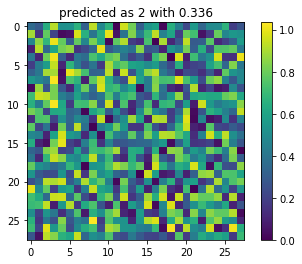

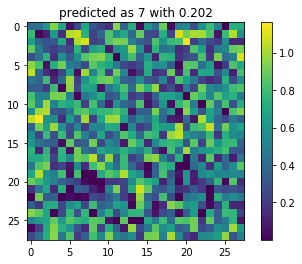

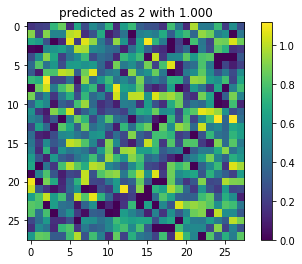

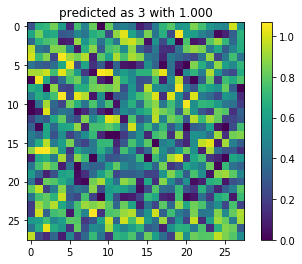

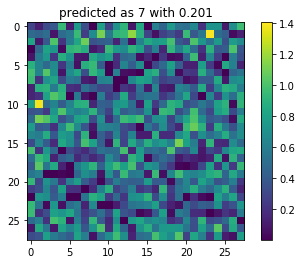

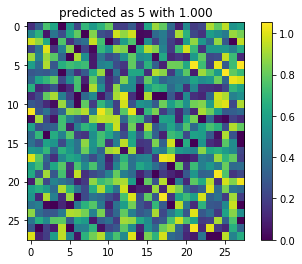

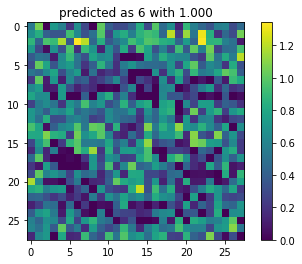

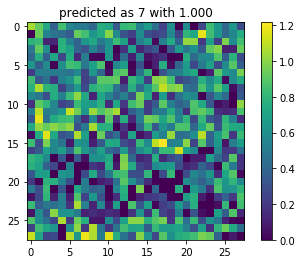

KeyboardInterrupt: 

In [15]:
for _ in range(10):
    optimize_best_input(_, start_with_random_array=True)